# Introduction

**The Business Scenario:** You are hired by a large Shopping Mall. They have a database of 200 customers, but they don't know "who" these people are. The Marketing Team wants to launch a campaign, but they can't afford to send the same email to everyone.

* **The Problem:** "We have customer with different incomes and spending habits. Can you group them into 'Tribes' so we can target them better?"
* **The Catch:** There is no "Tribe" column in the data. You have to invent the tribes yourself.

This is **Clustering**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df = pd.read_csv('Mall_Customers.csv')

print(df.head())
print(df.shape)
print(df.info())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
(200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


---

#### **The "Eye Test"**
In *Unsupervised Learning*, your eyes are often the best first tool. We want to see if natural groups exist begore we ask the math to find them.

We are interested in two main drivers:
1. **Money**: `Annual Income`
2. **Behavior**: `Spending Score`

In [3]:
# Rename columns for easier grouping
df.rename(columns={
    'Annual Income (k$)': 'income',
    'Spending Score (1-100)': 'score'
}, inplace=True)

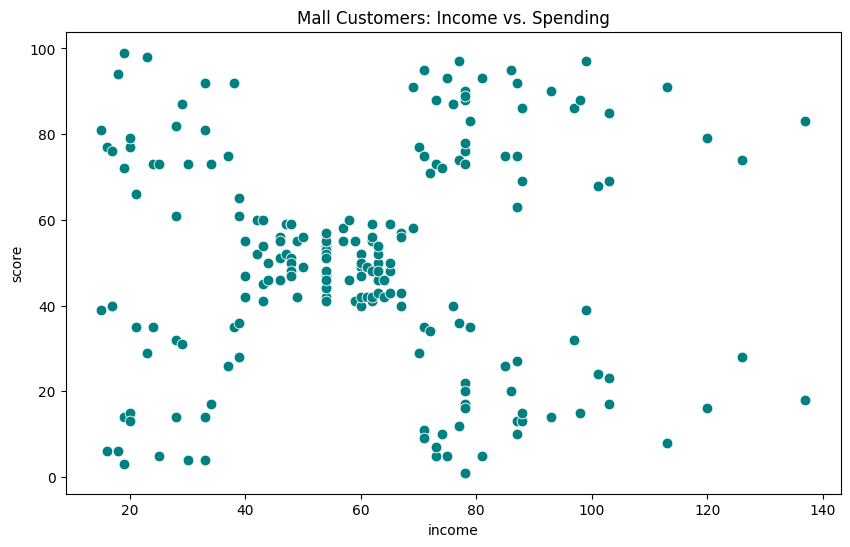

In [4]:
# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(df, x='income', y='score', s=60, color='teal')
plt.title("Mall Customers: Income vs. Spending")

plt.show()

There are atleast 5 groups with different `income` and `spending score`.

---

#### **The Math Check (The Elbow Method)**

While we can see 5 groups easily because it's 2D, real-world data often has 50 dimensions. We can't "see" 50D space.

We need a mathematical way to ask the computer: *"Hey, what is the perfect number of groups?"*

We use the **Elbow Method:**
1. We try clustering with **1 group**, then **2 groups**, then **3**, all the way to **10**.
2. For each attempt, we calculate the **"Error" (Inertia)**: *How far away are the points from the group center?*
3. We plot the Error. The line will drop sharply and then flatten out (like an elbow). The "Joint" of the elbow is the optimal number.

<function matplotlib.pyplot.show(close=None, block=None)>

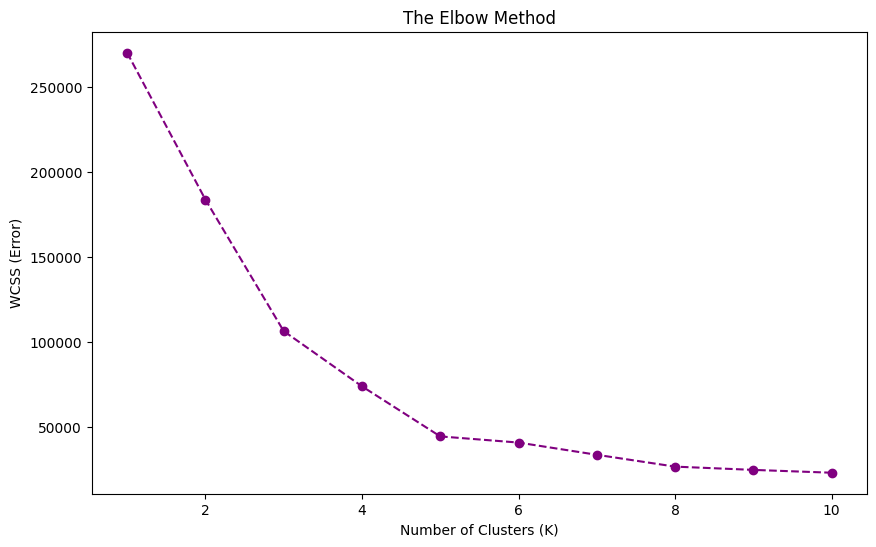

In [5]:
from sklearn.cluster import KMeans

# 1. Select the features we want to cluster
X = df[['income', 'score']]

# 2. Loop from k=1 to k=10
wcss = [] # "Whithin-Cluster Sum of Squares" (The Error)

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow
plt.figure(figsize=(10,6))
plt.plot(range(1,11), wcss, marker='o', linestyle='--', color='purple')
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Error)")

plt.show

It confirmed that K=5 is the optimal number of clusters (There're 5 clusters in the data).

---

#### Model

In [6]:
# 1. Initialize K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)

# 2. Fit the model and predict the cluster for each customer
# "y-kmeans" will be a list of numbers (0, 1, 2, 3, 4)
y_kmeans = kmeans.fit_predict(X)

# 3. Add the "Tribe" column to our original DataFrame so we can see it
df['cluster'] = y_kmeans

# 4. Check
print(df.head())

   CustomerID  Gender  Age  income  score  cluster
0           1    Male   19      15     39        4
1           2    Male   21      15     81        2
2           3  Female   20      16      6        4
3           4  Female   23      16     77        2
4           5  Female   31      17     40        4


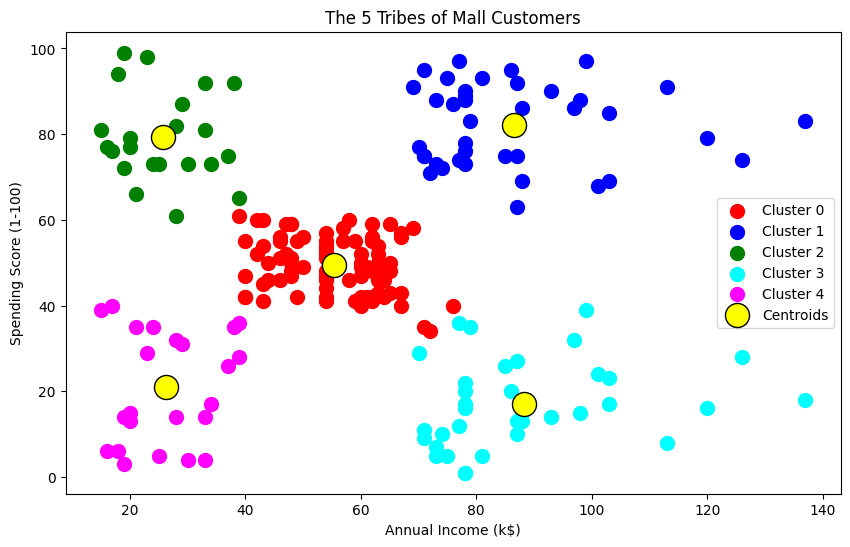

In [7]:
plt.figure(figsize=(10,6))

# Loop through each cluster (0 to 4) and plot them
colors=['red', 'blue', 'green', 'cyan', 'magenta']
for i in range(5):
    plt.scatter(X[y_kmeans == i]['income'],
                X[y_kmeans == i]['score'],
                s=100, c=colors[i], 
                label=f"Cluster {i}")
    
# Plot the "Centroids" (The center point of each cluster)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1],
            s=300, c='yellow', label='Centroids', edgecolors='black')

plt.title('The 5 Tribes of Mall Customers')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()

plt.show()

#### Inference:
1. **The "Miser" (High Income, Low Score):**
* **Cyan (Cluster 3)** (Bottom Right)
* **The Profile:** These people earn a lot of money (High X), but they barely spend a dime in your mall (Low Y).
* **The Business Insight:** Why? Maybe they are super frugal. OR...maybe they are shopping at your competitor's mall because your high-end stores aren't good enough.
* **The Strategy:** "Win them Over": Send them premium offers, VIP invitations, or advertise your luxury brands. We know they have the money; we just need to unlock it.

2. **The "Impulse Buyer" (Low Income, High Score)**:
* **Green (Cluster 2)** (Top Left)
* **The Profile:** They don't earn much (Low X), but they spend like crazy (High Y).
* **The Business Insight:** Who are they? Often these are college students using credit cards, or young people living with parents. They love trends and fashion.
* **The Strategy: "Protect & Retain."** They are loyal but price-sensitive. Send them discount coupons, "Sale" alerts, or buy-one-get-one-free deals. Do not send thme ads for $5,000 Rolex watches.


3. **The "Standard Customer" (Average Income, Average Score)**:
* **Red (Cluster 0)**(The big blob in the middle)
* **The Profile**: They earn an average salary and spend an average amount.
* **The Business Insight**: This is the bulk of your traffic (The "Bread and Butter"). They aren't exciting, but they keep the lights on.
* **The Strategy: "Don't annoy them."** Just keep them steady with a standard Loyalty Program. You don't need aggressive tactics here.